# Loading in and opening the data

the data is uploaded as a zip file and opened into folder target_dir; 
the csv is opened into 'data_csv'; 
the counter checks the number of samples from each device

In [1]:
from google.colab import drive
import pandas as pd
from collections import Counter
import numpy as np
import pylab
import matplotlib.pyplot as plt
import random
import math

In [2]:
drive.mount('/content/gdrive')
!unzip gdrive/My\ Drive/Beehive\ monitor/data/data_2_1.zip > /dev/null
!unzip gdrive/My\ Drive/Beehive\ monitor/data/data_1_1.zip > /dev/null


Mounted at /content/gdrive


In [2]:
data_csv = pd.read_csv('gdrive/My Drive/Beehive monitor/data/data_combined.csv')
data_csv.head()

,Unnamed: 0,device,date,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,gust speed,weatherID,cloud coverage,rain,lat,long,file name,queen,frames
0,0,1,2021-07-31 12:09:27,35.65,30.02,1010.88,25.72,49,1017,1.79,3.58,801,20,0,37.29,-121.95,2021-07-31--12-09-27_1.raw,1,8
1,1,1,2021-07-31 12:39:11,35.66,30.54,1010.61,26.34,44,1017,3.09,NaN,801,20,0,37.29,-121.95,2021-07-31--12-39-11_1.raw,1,8
2,2,1,2021-07-31 13:08:59,35.35,32.29,1010.36,27.53,48,951,0.45,2.24,801,20,0,37.29,-121.95,2021-07-31--13-08-59_1.raw,1,8
3,3,1,2021-07-31 13:38:43,35.65,33.34,1010.34,27.94,45,1016,1.34,2.24,801,20,0,37.29,-121.95,2021-07-31--13-38-43_1.raw,1,8
4,4,1,2021-07-31 14:08:29,35.39,33.70,1010.23,28.51,45,1015,0.89,2.24,801,20,0,37.29,-121.95,2021-07-31--14-08-29_1.raw,1,8


In [3]:
Counter(data_csv['device'])

Counter({1: 167, 2: 149})

# Sample loading and visualizing a single raw file

load a sound file from the folder; 
see the length of the file;
show a plot of the sound file


In [4]:
data = np.memmap("data_1/2021-07-31--12-39-11_1.raw", dtype='h', mode='r')
print(data)

[   0    0    0 ... 3964 4277 4438]


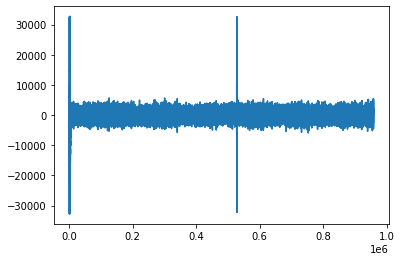

In [5]:
pylab.plot(data)
pylab.show()

In [6]:
len(data)

958464

# Processing the sound data

add every sound file to a list 'l'; get the length of the list; plot a random file

In [7]:
l = []
for i in data_csv['file name']:
  folder = "data_1/"
  if i[-5:-4] == '2':
    folder = "data_2/"
  data = np.memmap(folder+i, dtype='h', mode='r')
  l.append(data)

In [8]:
len(l)

316

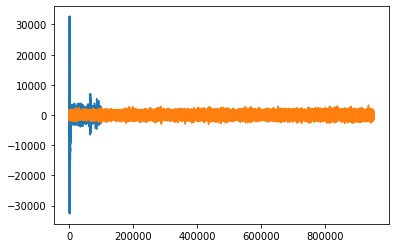

In [9]:
plt.plot(l[random.randint(0, len(l))][:100000])
plt.plot(l[random.randint(0, len(l))][8000:])
plt.show()

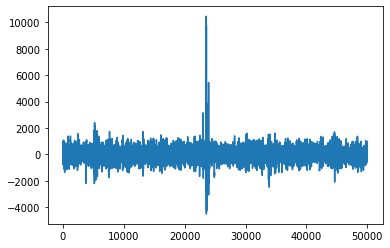

In [10]:
plt.plot(l[random.randint(0, len(l))][100000:150000])

In [43]:
l_uni = np.empty((len(l),500),float)
for i,val in enumerate(l):
  val2 = np.array(val[100000:100500])
  l_uni[i]=val2
l_uni.shape

(316, 500)

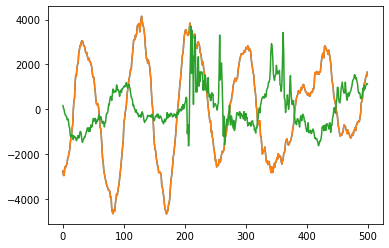

In [54]:
plt.plot(l_uni[0])
plt.plot(l[0][100000:100500])
plt.plot(l_uni[200])

# Get model and train

split the data into test and training sets (by device number); print the test set; print the lengths of the training sets; run a logistic regression model on the training sets

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from tensorflow import keras
from tensorflow.keras import layers

In [59]:
y = np.array(data_csv['device'])
X_train, X_test, y_train, y_test = train_test_split(l_uni, np.array(y), test_size=0.10, random_state=42)

# basic logistic regression model

In [60]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [61]:
predictions = logreg.predict(X_test)
acc = accuracy_score(predictions, y_test)
print(acc)

0.375


# Custom MLP

if the label is 1 -> label is 0. [1, 0]
if the label is 2 -> label is 1. [0, 1] 

In [62]:
y_train_onehot = np.zeros((len(y_train), 2))
y_train_onehot[np.arange(len(y_train)),y_train-1] = 1
y_test_onehot = np.zeros((len(y_test), 2))
y_test_onehot[np.arange(len(y_test)),y_test-1] = 1

In [78]:
input_shape = (500,)
num_classes = 2
model = keras.Sequential(
    [
     layers.Dense(32,input_shape=input_shape,activation="relu"),
     layers.Dense(8,activation="relu"),
     layers.Dense(num_classes, activation="softmax")
    ])
    

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(0.0001),
    metrics=["accuracy"]
)

history = model.fit(X_train, 
                    y_train_onehot, 
                    batch_size=32,
                    epochs=80,
                    validation_data=(X_test, y_test_onehot)
                    )


Epoch 1/80
9/9 [==============================] - 1s 49ms/step - loss: 202.1593 - accuracy: 0.5141 - val_loss: 163.5772 - val_accuracy: 0.5938
Epoch 2/80
9/9 [==============================] - 0s 13ms/step - loss: 169.5895 - accuracy: 0.5282 - val_loss: 147.7945 - val_accuracy: 0.5938
Epoch 3/80
9/9 [==============================] - 0s 12ms/step - loss: 148.9086 - accuracy: 0.5352 - val_loss: 132.6748 - val_accuracy: 0.5938
Epoch 4/80
9/9 [==============================] - 0s 10ms/step - loss: 129.1902 - accuracy: 0.5282 - val_loss: 121.1365 - val_accuracy: 0.5312
Epoch 5/80
9/9 [==============================] - 0s 11ms/step - loss: 114.2394 - accuracy: 0.5211 - val_loss: 109.8387 - val_accuracy: 0.5625
Epoch 6/80
9/9 [==============================] - 0s 12ms/step - loss: 99.1748 - accuracy: 0.5528 - val_loss: 100.7745 - val_accuracy: 0.5938
Epoch 7/80
9/9 [==============================] - 0s 6ms/step - loss: 88.5675 - accuracy: 0.5528 - val_loss: 93.6456 - val_accuracy: 0.5312
Epo

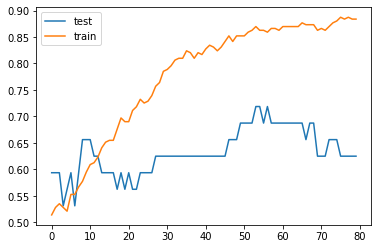

In [79]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.legend(['test', 'train'], loc='upper left')